Contributed by: MANISH SONI

Github Repository:https://github.com/thewitking/billing-system

# Billing system based on Image segmentation or product detection

This Jupyter notebook implements a transfer learning approach using an already pretrained deep neural network. 
Consider that an entity serving their customers different kind of packaged food products, uses such approach to generate bills for all the purchased item using just a picture of such items.

Deep Neural network used for segmentation: Retinanet [Fizyr implementation](https://github.com/fizyr/keras-retinanet) of RetinaNet in Keras.

It requires product image dataset with proper annotations.

Tools used: Tensorflow, keras, python3, Jupyter notebook,
Platform for model training: GPU enabled GCP instance

# Initial Setup

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [2]:
%cd keras-retinanet/

!pip3 install .

/home/ms11313/exp3/objdet_fizyr_colab/keras-retinanet
Processing /home/ms11313/exp3/objdet_fizyr_colab/keras-retinanet
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/14/49/8f13fa215e10a7ab0731cc95b0e9bb66cf83c6a98260b154cfbd0b55fb19/scipy-1.3.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e7/bd/59054534d09830394470c14e4dd4a2e8fa64ac14559095a044208bf34c18/Cython-0.29.7-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/de/62/6358ccd27b9e340affaa29e3e678b5d93a4b17f6bd7533fd6e6e87930b12/Pillow-6.0.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fe/c8/421eeac

In [3]:
!python3 setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.5/keras_retinanet/utils/compute_overlap.cpython-35m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [4]:
! pwd
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
import keras

/home/ms11313/exp3/objdet_fizyr_colab/keras-retinanet


Using TensorFlow backend.


# Product Image Dataset

we need all the annotations related to images in Fizyr annotations format.

sample dataset is available in repository :

```
dataset.zip
|- cheetos
    |- 001.jpg
    |- 002.jpg
    ...
|- reese
    |- 101.jpg
    |- 102.jpg
    ...
|- pringle
    |- 201.jpg
    |- 202.jpg
    ...
...
```


In [5]:
!cp ./../dataset.zip ./

In [6]:
IMG_DATASET_DIR = 'dataset'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [7]:
file_name = IMG_DATASET_DIR + '.zip'

os.makedirs(IMG_DATASET_DIR, exist_ok=True)
with zipfile.ZipFile(file_name, 'r') as zip_src:
  zip_src.extractall(IMG_DATASET_DIR)
os.remove(file_name)
print('File Unziped')

File Unziped


In [8]:
import os
annotations = []
classes = set([])
abcdir='dataset'
tarSET_DIR=IMG_DATASET_DIR+'/'+abcdir
#for root, dirs, files in os.walk(dir):
for roott, dirst, filest in os.walk(tarSET_DIR):
    for xml_file in [f for f in filest if f.endswith(".xml")]:
        filepath=os.path.join(roott, xml_file)
        tree = ET.parse(filepath)
        root = tree.getroot()
        file_name = None
        for elem in root:
            if elem.tag == 'filename':
                file_name = os.path.join(roott, elem.text)
            if elem.tag == 'object':
                obj_name = None
                coords = []
                for subelem in elem:
                    if subelem.tag == 'name':
                        obj_name = subelem.text
                    if subelem.tag == 'bndbox':
                        for subsubelem in subelem:
                            coords.append(subsubelem.text)
                item = [file_name] + coords + [obj_name]
                annotations.append(item)
                classes.add(obj_name)
            

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

# Get a Pretrained model

First step is to get a pretrained model.


Lets download Fizyr Resnet50 pretrained model



In [9]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('pretrained model available at: ' + PRETRAINED_MODEL)

pretrained model available at: ./snapshots/_pretrained_model.h5


# Training Model on Product Image dataset

Lets use commandline arguements to train the model.




In [10]:
!python3 keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

Using TensorFlow backend.
2019-05-20 01:56:37.100965: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-05-20 01:56:37.232245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-05-20 01:56:37.233254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
totalMemory: 15.90GiB freeMemory: 15.56GiB
2019-05-20 01:56:37.233312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1435] Adding visible gpu devices: 0
2019-05-20 01:56:37.700142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:923] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-05-20 01:56:37.700213: I tensorflow/core/common_runtim

Epoch 1/10
500/500 [==============================] - 833s 2s/step - loss: 1.4444 - regression_loss: 0.7845 - classification_loss: 0.6599

Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
Epoch 2/10
500/500 [==============================] - 821s 2s/step - loss: 0.7364 - regression_loss: 0.5279 - classification_loss: 0.2085

Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
Epoch 3/10
500/500 [==============================] - 832s 2s/step - loss: 0.5457 - regression_loss: 0.4273 - classification_loss: 0.1185

Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
Epoch 4/10
500/500 [==============================] - 833s 2s/step - loss: 0.4597 - regression_loss: 0.3778 - classification_loss: 0.0819

Epoch 00004: saving model to ./snapshots/resnet50_csv_04.h5
Epoch 5/10
500/500 [==============================] - 826s 2s/step - loss: 0.4028 - regression_loss: 0.3411 - classification_loss: 0.0617

Epoch 00005: saving model to ./snapshots/resnet50_csv_05.h5
Epoch

# Inference
This step involves prediction or inference score generation for different products detected in test image.

In [10]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

In [11]:
CLASSES_FILE = 'classes.csv'
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5


In [12]:
THRES_SCORE = 0.45
def img_inference(img_path):
    image = read_image_bgr(img_infer)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    # correct for image scale
    boxes /= scale
    product_lables=[]
    inference_scores=[]
    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < THRES_SCORE:
            break
        color = label_color(label)
        product_lables.append(label)
        inference_scores.append(score)
        b = box.astype(int)
        draw_box(draw, b, color=color)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    return product_lables,inference_scores

Running inference on: test9.jpg
processing time:  13.122014999389648


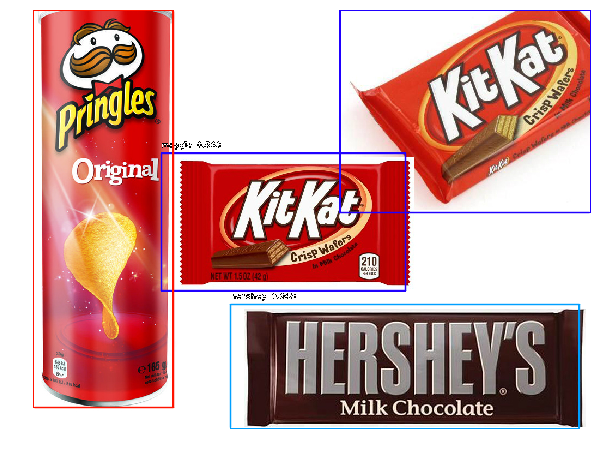

products labels are: [1, 0, 0, 3]


[[0, 159, 255], [31, 0, 255], [31, 0, 255], [255, 19, 0]]

In [13]:

img_infer='test9.jpg'
print('Running inference on: ' + img_infer)
products,scores=img_inference(img_infer)
print("products labels are:",products)

colors=[]
for lab in products:
    b=label_color(lab)
    colors.append(b)
colors

Text(0, 0.5, 'score')

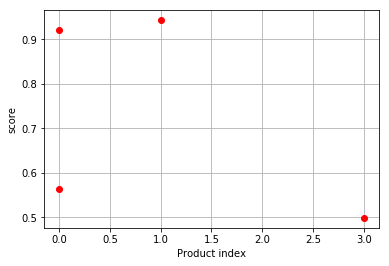

In [14]:
plt.plot(products,scores,'ro',linewidth=2)
plt.grid()
plt.xlabel('Product index')
plt.ylabel('score')

In [15]:
PRICE_FILE='./../prices.csv'
df = pandas.read_csv(PRICE_FILE,header=None)
def calculate_price_for_label(label):
    col=df[df[0]==label].index.item()
    price=df[1][col]
    return price
print("Price table")
df

Price table


,0,1
0,kitkat,2.99
1,hershey,5.00
2,reese,2.99
3,pringle,1.67
4,maggie,0.57
5,cheetos,1.59


In [16]:
total=0.0
print("products :",products)
for label in products:
    product=labels_to_names[label]
    print("item:",product)
    price=calculate_price_for_label(product)
    print("item:",label)
    print("price:",price)
    print("\n")
    total=total+float(price)
print("Total Amount=",total)

products : [1, 0, 0, 3]
item: hershey
item: 1
price: 5.0


item: maggie
item: 0
price: 0.57


item: maggie
item: 0
price: 0.57


item: reese
item: 3
price: 2.99


Total Amount= 9.13


# Conclusion

This jupyter notebook aims to use a pretrained model and to transer that learning for training on product image dataset to detect various products in image so to calculate the final bill amount.


